# ML Homework 2

**Gede Ria Ghosalya - 1001841**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import theano
import theano.tensor as T

In [2]:
csv='https://www.dropbox.com/s/oqoyy9p849ewzt2/linear.csv?dl=1'
data = np.genfromtxt(csv, delimiter=',')

### Q1. Ridge Regression with Offset

---
**a)** Let the first 10 entries of the data set be the validation set, and the last 40 entries to be the training set. Concatenate their features into matrices vX and tX, and their responses into vectors vY and tY. Print the shapes of vX, tX, vY, tY.

In [3]:
vdata = data[0:10,:]
tdata = data[10:,:]
vX = vdata[:,1:]
vY = vdata[:,0]
tX = tdata[:,1:]
tY = tdata[:,0]

print("""
vX shape:{vx}
vY shape:{vy}
tX shape:{tx}
tY shape:{ty}
"""\
.format(vx=vX.shape,
        vy=vY.shape,
        tx=tX.shape,
        ty=tY.shape))


vX shape:(10, 4)
vY shape:(10,)
tX shape:(40, 4)
tY shape:(40,)



 ---
**b)** Write a program in Theano that performs ridge regression by using a regularization penalty of 0.5λ||_w_||^2 with λ=0.15. You may use the source codes from Homework 1. Print the resulting value of _w_. Which feature may we assume to be irrelevant?

In [4]:
def ridge_regression(X, Y, lamb=0.15, learn_rate=0.5):
    d = X.shape[1] 
    n = X.shape[0]
    x = T.matrix(name='x')
    y = T.vector(name='y')
    w = theano.shared(np.zeros((d,1)),name='w')
    regularizer = 0.5*lamb*(T.dot(w[:-1].T,w[:-1])[0,0])
    point_loss = 0.5*(T.dot(x,w).T-y)**2
    risk = (T.sum(point_loss))/n + regularizer
    grad_risk = T.grad(risk, wrt=w)
    train_model = theano.function(inputs=[],
                                  outputs=risk,
                                  updates=[(w, w-learn_rate*grad_risk)],
                                  givens={x:X,y:Y})
    training = [train_model() for i in range(100)]
    return w.get_value()

w = ridge_regression(tX, tY)
wp = ridge_regression(tX, tY, 0.5)
print('with lambda=0.15, w:\n\n',w,'\n\nwith lambda=0.5, w:\n\n', wp)

with lambda=0.15, w:

 [[-0.53590673]
 [ 1.20293332]
 [ 0.04334568]
 [-1.85492455]] 

with lambda=0.5, w:

 [[-0.4577457 ]
 [ 0.9361236 ]
 [ 0.0534599 ]
 [-1.81257696]]


At this point, it is hard to tell which feature is irrelevant

---
**c)** Compute the optimal solution using BFGS optimizer from `scipy`.

In [5]:
from scipy.optimize import fmin_l_bfgs_b as minimize

def ridgecost(w,X,Y,lamb):
    n = X.shape[0]
    regularizer = 0.5*lamb*np.dot(w[:-1].T,w[:-1])
    point_loss = 0.5*(np.dot(X,w).T-Y)**2
    risk = (np.sum(point_loss))/n + regularizer
    j = np.identity(X.shape[1])
    j[-1,-1] = 0
    grad = lamb*np.dot(j,w) + np.dot(np.dot(X.T,X),w)/n - np.dot(X.T,Y)/n
    return risk, grad

d = tX.shape[1]
w = np.zeros((d,1))

optx, cost, messages = minimize(ridgecost, w, args=[tX,tY,0.15])
print(optx)

[-0.53591305  1.20293347  0.04332715 -1.85492236]


---
**d)** Write a function `ridge_regression(tX, tY, l)` that takes the training features, training responses and regularizing parameter λ, and output the exact solution _w_ for ridge regression with offset. Print the resulting value of _w_ for λ=0.15.

In [6]:
def ridge_regression(X, Y, l):
    n, d = X.shape
    j = np.identity(d)
    j[-1,-1] = 0
    j_matrix = n*l*j
    xtx = np.dot(X.T, X)
    term = j_matrix + xtx
    in_xtx = np.linalg.inv(term)
    xty = np.dot(X.T, Y)
    exact = np.dot(in_xtx, xty)
    return exact


we = ridge_regression(tX, tY, 0.15)
print(we)

[-0.53590673  1.20293332  0.04334568 -1.85492455]


---
**e)** Use the following code to plot graphs of the validation loss and training loss as λ varies on a logarithmic scale from λ=10e-5 to λ=10e0.

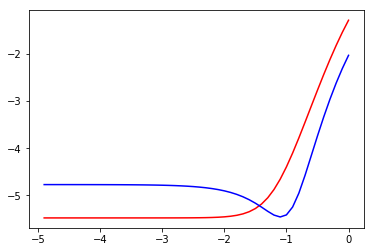

In [7]:
tn = tX.shape[0]
vn = vX.shape[0]
tloss = []
vloss = []
index = -np.arange(0,5,0.1)
for i in index:
    w = ridge_regression(tX, tY, 10**i)
    tloss = tloss+[np.sum((np.dot(tX,w)-tY)**2)/(2*tn)]
    vloss = vloss+[np.sum((np.dot(vX,w)-vY)**2)/(2*vn)]

import matplotlib.pyplot as plt
plt.plot(index, np.log(tloss),'r')
plt.plot(index, np.log(vloss),'b')
    

Looking at the validation line (blue), it can be seen that the validation loss is lowest when **λ=10e-5**.

### Q2. Clustering


In [8]:
import numpy.random as rng
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

n_colors = 32
pic = 'http://www.dropbox.com/s/bmwwfct2qxjfje4/sutd.png?dl=1'
img = mpimg.imread(pic)
img = img[:,:,:3]

w, h, d = tuple(img.shape)
image_array = np.reshape(img, (w * h, d))

In [9]:
def recreate_image(palette, labels, w, h):
    d = palette.shape[1]
    image = np.zeros((w,h,d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = palette[labels[label_idx]]
            label_idx += 1
    return image

---
**a)** Sampling 1000 pixels at random

In [10]:
rand_index = np.random.randint(0, w*h, 1000)
rand_img_sample = image_array[rand_index]

rand_cluster = KMeans(n_clusters=32).fit(rand_img_sample)
kmeans_palette = rand_cluster.cluster_centers_
kmeans_labels = rand_cluster.predict(image_array)

---
**b)** Sampling 32 pixels at random

In [11]:
rand_index = np.random.randint(0, w*h, 1000)
random_palette = image_array[rand_index]
pdam = pairwise_distances_argmin
random_labels = pdam(image_array, random_palette)


**Resulting plot:**

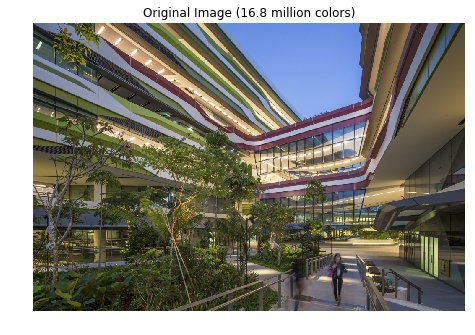

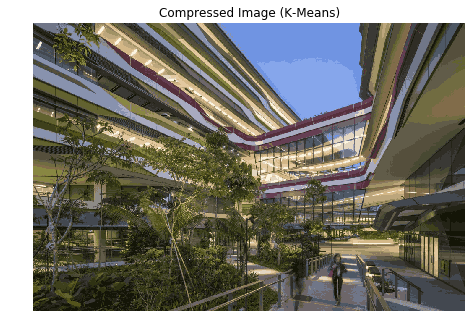

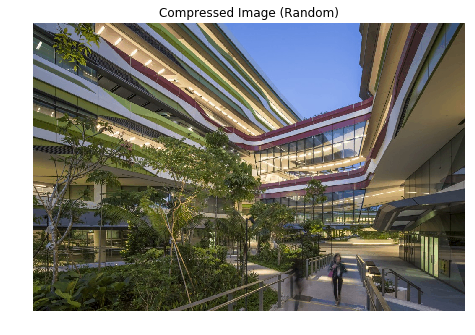

In [12]:

plt.figure(1)
plt.clf()
ax = plt.axes([0,0,1,1])
plt.axis('off')
plt.title('Original Image (16.8 million colors)')
plt.imshow(img)

plt.figure(2)
plt.clf()
ax = plt.axes([0,0,1,1])
plt.axis('off')
plt.title('Compressed Image (K-Means)')
plt.imshow(recreate_image(kmeans_palette, kmeans_labels, w, h))

plt.figure(3)
plt.clf()
ax = plt.axes([0,0,1,1])
plt.axis('off')
plt.title('Compressed Image (Random)')
plt.imshow(recreate_image(random_palette, random_labels, w, h))

plt.show()


---
**c)** See end of document.

### Q3. Logistic Regression

In [13]:
import numpy as np
import pandas as pd

X_data = pd.read_csv('kaggle_train.csv')
X_test = pd.read_csv('kaggle_test.csv')
X_valid = X_data.sample(frac=0.2, random_state=200)
X_train = X_data.drop(X_valid.index)
Y_data = X_data['Survived']
Y_train = X_train['Survived']
Y_valid = X_valid['Survived']
ID_test = X_test['PassengerId']


In [14]:
from IPython.display import display
print("\nKaggle's train.csv")
display(X_data.head())
display(X_data.describe())
print("\nKaggle's test.csv")
display(X_test.head())
display(X_test.describe())


Kaggle's train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Kaggle's test.csv


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [15]:
dropped_columns = ["PassengerId","Name","Ticket","Cabin"]
df = X_train.drop(dropped_columns, axis=1)
df.drop(["Survived"], axis=1, errors="ignore", inplace=True)
#imputing
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
df["Fare"].fillna(df["Fare"].median(), inplace=True)
df["Age"].fillna(df["Age"].mean(), inplace=True)

In [16]:
# one-hot encoding
df = df.join(pd.get_dummies(df["Embarked"]))
df.drop(["Embarked"], axis=1, inplace=True)
df = df.join(pd.get_dummies(df["Sex"]))
df.drop(["Sex"], axis=1, inplace=True)
df = df.join(pd.get_dummies(df["Pclass"]))
df.drop(["Pclass"], axis=1, inplace=True)

In [17]:
# feature engineering
df.loc[:,"Family"] = (df["SibSp"]+df["Parch"] > 0).astype(int)
df.loc[:,"Child"] = (df["Age"] < 16).astype(int)

In [18]:
def preprocess(df):
    dropped_columns = ["PassengerId","Name","Ticket","Cabin"]
    df = df.drop(dropped_columns, axis=1)
    df.drop(["Survived"], axis=1, errors="ignore", inplace=True)
    #imputing
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
    df["Fare"].fillna(df["Fare"].median(), inplace=True)
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    # one-hot encoding
    df = df.join(pd.get_dummies(df["Embarked"]))
    df.drop(["Embarked"], axis=1, inplace=True)
    df = df.join(pd.get_dummies(df["Sex"]))
    df.drop(["Sex"], axis=1, inplace=True)
    df = df.join(pd.get_dummies(df["Pclass"]))
    df.drop(["Pclass"], axis=1, inplace=True)
    # feature engineering
    df.loc[:,"Family"] = (df["SibSp"]+df["Parch"] > 0).astype(int)
    df.loc[:,"Child"] = (df["Age"] < 16).astype(int)
    return df    

---
**a)** Preprocessing all dataframes & displaying.

In [19]:
X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_data = preprocess(X_data)
X_test = preprocess(X_test)

print('\nTrain')
display(X_train.head())
print('\nValidation')
display(X_valid.head())
print('\nData')
display(X_data.head())
print('\nTest')
display(X_test.head())


Train


,Age,SibSp,Parch,Fare,C,Q,S,female,male,1,2,3,Family,Child
0,22.000000,1,0,7.2500,0,0,1,0,1,0,0,1,1,0
2,26.000000,0,0,7.9250,0,0,1,1,0,0,0,1,0,0
3,35.000000,1,0,53.1000,0,0,1,1,0,1,0,0,1,0
4,35.000000,0,0,8.0500,0,0,1,0,1,0,0,1,0,0
5,29.449243,0,0,8.4583,0,1,0,0,1,0,0,1,0,0



Validation


,Age,SibSp,Parch,Fare,C,Q,S,female,male,1,2,3,Family,Child
659,58.000000,0,2,113.2750,1,0,0,0,1,1,0,0,1,0
525,40.500000,0,0,7.7500,0,1,0,0,1,0,0,1,0,0
828,30.671233,0,0,7.7500,0,1,0,0,1,0,0,1,0,0
753,23.000000,0,0,7.8958,0,0,1,0,1,0,0,1,0,0
518,36.000000,1,0,26.0000,0,0,1,1,0,0,1,0,1,0



Data


,Age,SibSp,Parch,Fare,C,Q,S,female,male,1,2,3,Family,Child
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,1,0
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,0
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,0



Test


,Age,SibSp,Parch,Fare,C,Q,S,female,male,1,2,3,Family,Child
0,34.5,0,0,7.8292,0,1,0,0,1,0,0,1,0,0
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1,1,0
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1,0,0
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1,1,0


---
**b)** Using `LogisticRegression` from the `sklearn.linear_model` module, fit a classifier to the training set `X_train` and `Y_train`. Evaluate the accuracy of the classifier via the validation set `X_valid` and `Y_valid`. What is the score?

In [20]:
from sklearn.linear_model import LogisticRegression as logres
logres_model = logres().fit(X_train, Y_train)
logres_prediction = logres_model.predict(X_valid)
logres_score = logres_model.score(X_valid, Y_valid)
print('Accuracy: ',logres_score)

Accuracy:  0.792134831461


---
**c)** Fit a classifier to the data `X_data` and `Y_data`. What is the value of the parameter?

In [21]:
alldata_model = logres().fit(X_data, Y_data)
parameters = alldata_model.get_params()
print('Parameters: ',parameters)

Parameters:  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


---
**d)** Apply classifier in (c) to the test data `X_test`. Let `Y_test` denote the predicted labels. You are welcome to tweak the code to improve your model. Use the following code to prepare a submission file for Kaggle.

In [22]:
X_data = pd.read_csv('kaggle_train.csv')
X_test = pd.read_csv('kaggle_test.csv')
X_valid = X_data.sample(frac=0.2, random_state=200)
X_train = X_data.drop(X_valid.index)
Y_data = X_data['Survived']
Y_train = X_train['Survived']
Y_valid = X_valid['Survived']


def tweaked_preprocess(df):
    dropped_columns = ["PassengerId","Name","Ticket","Cabin"]
    df = df.drop(dropped_columns, axis=1)
    df.drop(["Survived"], axis=1, errors="ignore", inplace=True)
    #imputing
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
    df["Fare"].fillna(df["Fare"].median(), inplace=True)
    df["Age"].fillna(df["Age"].mean(), inplace=True)
    # one-hot encoding
    df = df.join(pd.get_dummies(df["Embarked"]))
    df.drop(["Embarked"], axis=1, inplace=True)
    df = df.join(pd.get_dummies(df["Sex"]))
    df.drop(["Sex"], axis=1, inplace=True)
    # feature engineering
    df.loc[:,"Family"] = (df["SibSp"]+df["Parch"] > 0).astype(int)
    df.loc[:,"Child"] = (df["Age"] < 16).astype(int)
    return df    


X_train = tweaked_preprocess(X_train)
X_valid = tweaked_preprocess(X_valid)
X_data = tweaked_preprocess(X_data)
X_test = tweaked_preprocess(X_test)

tweaked_model = logres().fit(X_train, Y_train)
accuracy = tweaked_model.score(X_valid, Y_valid)

print("Accuracy: ",accuracy)

Accuracy:  0.803370786517


In [23]:
Y_test = tweaked_model.predict(X_test)

ans = pd.DataFrame({"PassengerId":ID_test,"Survived":Y_test})
ans.to_csv("submit.csv", index=False)

![score](kagglescore.png)

---
**Q2c)** Given a cluster {x(1), x(2), ..., x(m)} of points, prove that the point _z_ minimizing SUM(|x(i) -z|^2) is the centroid.

![Answer](prove.jpg)